<a href="https://colab.research.google.com/github/trashchenkov/gigachat_tutorials/blob/main/RAG_%D0%BF%D0%BE_%D1%81%D1%82%D0%B0%D1%82%D1%8C%D1%8F%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание простой вопросно-ответной системы
## Что из себя представляют вопросно-ответные системы с использованием языковых моделей

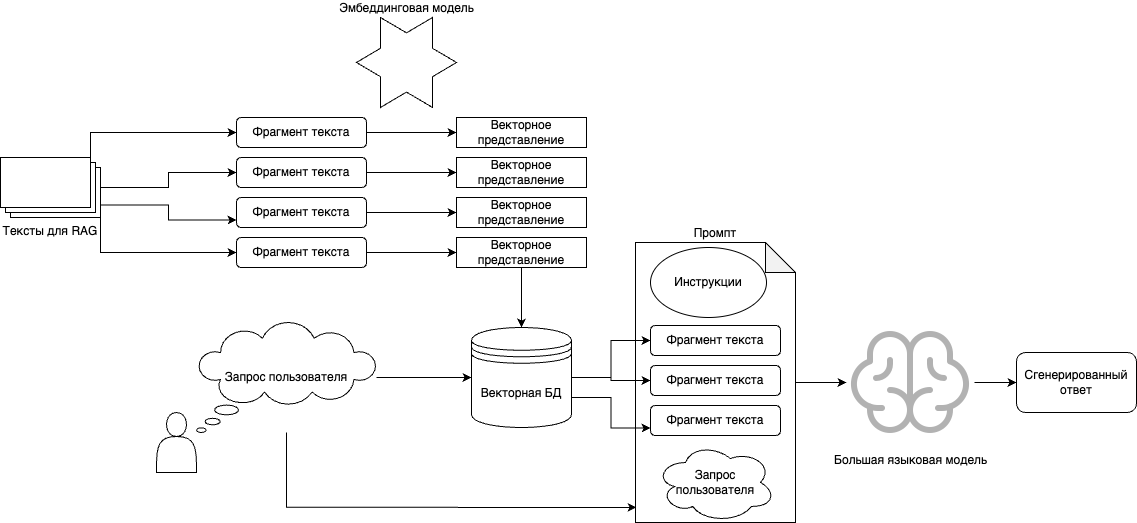

## Установка требуемых библиотек

В рамках туториала нам потребуется некоторое количество инструментов:
- `gigachain` - основной инструмент построения пайплайнов с большими языковыми моделями;
- `faiss-cpu` - используем векторное хранилище FAISS для размещения чанков (фрагментов текстов для контекста)и эмбеддингов (векторных представлений) этих чанков;
- `sentence-transformers` - библиотека для локального использования эмбеддинговых моделей с ресурса Hugging Face;
- `rank_bm25` - библиотека для работы с алгоритмами векторизации BM25 (вариации TF-IDF);
- `playwright` - библиотека для автоматизации браузера, в нашем случае для парсинга списка статей с веб-сайта.

In [1]:
!pip install gigachain faiss-cpu sentence-transformers rank_bm25 playwright --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.2/306.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

Также выполним установку браузера для сбора списка статей.

In [2]:
!playwright install

155.3 MiB [] 0% 0.0s155.3 MiB [] 0% 26.6s155.3 MiB [] 0% 22.5s155.3 MiB [] 0% 11.5s155.3 MiB [] 0% 8.2s155.3 MiB [] 1% 6.7s155.3 MiB [] 1% 6.3s155.3 MiB [] 1% 5.8s155.3 MiB [] 2% 5.3s155.3 MiB [] 2% 5.5s155.3 MiB [] 2% 5.7s155.3 MiB [] 3% 5.5s155.3 MiB [] 3% 5.9s155.3 MiB [] 3% 5.6s155.3 MiB [] 4% 5.3s155.3 MiB [] 4% 5.7s155.3 MiB [] 4% 5.8s155.3 MiB [] 4% 5.6s155.3 MiB [] 5% 5.5s155.3 MiB [] 5% 5.2s155.3 MiB [] 6% 5.0s155.3 MiB [] 7% 4.9s155.3 MiB [] 7% 4.8s155.3 MiB [] 8% 4.6s155.3 MiB [] 8% 4.4s155.3 MiB [] 9% 4.4s155.3 MiB [] 9% 4.5s155.3 MiB [] 10% 4.4s155.3 MiB [] 10% 4.3s155.3 MiB [] 11% 4.3s155.3 MiB [] 11% 4.2s155.3 MiB [] 11% 4.3s155.3 MiB [] 12% 4.3s155.3 MiB [] 12% 4.2s155.3 MiB [] 13% 4.2s155.3 MiB [] 14% 4.1s155.3 MiB [] 14% 4.2s155.3 MiB [] 15% 4.2s155.3 MiB [] 15% 4.1s155.3 MiB [] 16% 4.1s155.3 MiB [] 16% 4.0s155.3 MiB [] 17% 4.0s155.3 MiB [] 18% 3.8s155.3 MiB [] 19% 3.6s155.3 MiB [] 20% 3.5s155.3 MiB [] 20% 3.4s155.3 MiB [] 21% 3.4s155.3 MiB [] 22% 3.3s155.3 MiB [] 22%

## Выполним сбор статей
В качестве источника знаний используем статьи с научно-популярного сайта [N + 1](https://nplus1.ru/). Возьмем последние статьи по космонавтике.

Используем `AsyncChromiumLoader` из GigaChain для загрузки страницы. Этот инструмент приходится использовать, потому что выборка статей по направлениям подгружает перечень статей не сразу, а значит получить его обычным запросом `requests.get()` не получится.

Из-за асинхронной работы `AsyncChromiumLoader` сделаем сбор статей отдельным скриптом.

В результате выполнения скрипта мы получим отдельный текстовый файл со ссылками на статьи по космической тематике.

In [3]:
%%writefile parser.py

from langchain_community.document_loaders import AsyncChromiumLoader
from bs4 import BeautifulSoup

# Инициализируем загрузчик
loader = AsyncChromiumLoader(["https://nplus1.ru/search?tags=871"])
html = loader.load()
articles = 'n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24'
with open('page.html', 'w') as f:
  f.write(html[0].page_content)
soup = BeautifulSoup(html[0].page_content, 'html.parser')
links = []
with open('links.txt', 'w') as f:
  for link in soup.find_all('a', class_=articles):
    print(link)
    links.append(link['href'])
    f.write(link['href']+' ')


Writing parser.py


In [4]:
!python parser.py

<a class="n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24" href="https://nplus1.ru/news/2024/05/11/icube-q-photos"><div>Первый пакистанский лунный кубсат прислал снимки с окололунной орбиты</div><!-- --></a>
<a class="n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24" href="https://nplus1.ru/news/2024/05/03/change-6-launch"><div>Китайская автоматическая станция «Чанъэ-6» отправилась к Луне</div><!-- --></a>
<a class="n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24" href="https://nplus1.ru/news/2024/04/26/tess-is-over-or-what"><div>Телескоп TESS второй раз за месяц ушел в безопасный режим</div><!-- --></a>
<a class="n1_climb_4 transition-colors duration-75 hover:text-main inline-block mb-10 sm:mb-5 font-spectral leading-24" href="https://nplus1.ru/news/2024/04/18/dragonfly-go"><div>NASA одобрило постройку окт

## Подготовка фрагментов статей, векторизация и загрузка в векторную БД

Откроем файл со ссылками.

In [5]:

with open('links.txt') as f:
  sources = f.read()

print(sources.split())


['https://nplus1.ru/news/2024/05/11/icube-q-photos', 'https://nplus1.ru/news/2024/05/03/change-6-launch', 'https://nplus1.ru/news/2024/04/26/tess-is-over-or-what', 'https://nplus1.ru/news/2024/04/18/dragonfly-go', 'https://nplus1.ru/news/2024/04/12/spacehopper', 'https://nplus1.ru/news/2024/04/09/delta-heavy-finally', 'https://nplus1.ru/news/2024/03/29/euclid-ice', 'https://nplus1.ru/news/2024/05/09/change-6-lunar-orbit', 'https://nplus1.ru/news/2024/05/01/hubble-recovery', 'https://nplus1.ru/news/2024/04/24/slim-awake-again-and-again', 'https://nplus1.ru/news/2024/04/18/ingenuity-will-work-until-death', 'https://nplus1.ru/news/2024/04/11/danuri-lro', 'https://nplus1.ru/news/2024/04/06/super-heavy-b11-static-fire-test', 'https://nplus1.ru/news/2024/03/28/slim-awake-again', 'https://nplus1.ru/news/2024/05/09/tess-on', 'https://nplus1.ru/news/2024/04/30/psyche-transmits-laser', 'https://nplus1.ru/news/2024/04/23/voyager-1-no-ill', 'https://nplus1.ru/news/2024/04/16/iss-gift', 'https://np

Импортируем нужные инструменты.


In [7]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores.faiss import FAISS
from langchain_core.documents import Document

In [8]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

Осуществим загрузку веб-страниц по ссылкам.

In [9]:
loader = WebBaseLoader(sources.split())

In [10]:
docs = loader.load()

In [11]:
len(docs)

28

Разделим тексты статей на фрагменты длиной 500 символов и перекрытием в 100 символов.

In [12]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,
                                              chunk_overlap=100)
split_docs = text_splitter.split_documents(docs)

In [13]:
len(split_docs)

396

In [14]:
split_docs[1]

Document(page_content='Авторам\n              \n\n\nИгры\nФизика\nЗоология\nАстрономия\nГенетика\nМатематика\n\n\nКосмонавтика\nАрхеология\nНейронауки\nНа мышах\nЗвук\nКрасота\n\n\nНаучные закрытия\nИИ спешит на помощь\nКогда рассеется дым\nКнижная полка\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n                О нас\n              \n\n                Сложность\n              \n\n                Рекламодателям\n              \n\n                Авторам', metadata={'source': 'https://nplus1.ru/news/2024/05/11/icube-q-photos', 'title': 'Первый пакистанский лунный кубсат прислал снимки с\xa0окололунной орбиты. Он\xa0был запущен вместе со\xa0станцией «Чанъэ-6»', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'})

Создадим ретривер и векторное хранилище для врагментов текста.

- [Рейтинг ретриверов для английского языка](https://huggingface.co/spaces/mteb/leaderboard)
- [Рейтинг ретриверов для русского языка](https://github.com/avidale/encodechka#%D0%BB%D0%B8%D0%B4%D0%B5%D1%80%D0%B1%D0%BE%D1%80%D0%B4)
- [Эмбеддинговая модель, которую используем в этом туториале](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2)

In [15]:
%%time
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embedding = HuggingFaceEmbeddings(model_name=model_name,
                                  model_kwargs=model_kwargs,
                                  encode_kwargs=encode_kwargs)

vector_store = FAISS.from_documents(split_docs, embedding=embedding)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

CPU times: user 2min 22s, sys: 13.7 s, total: 2min 36s
Wall time: 2min 55s


Зададим параметры извлечения. В нашем случае установим, что на запрос должны возвращаться 5 фрагментов, наиболее близких по смыслу.

In [16]:
embedding_retriever = vector_store.as_retriever(search_kwargs={"k": 5})

## Создание генеративной части пайплайна и составление цепочки RAG системы

Используем авторизационные данные для подключения к GigaChat API.

In [17]:
from google.colab import userdata
auth = userdata.get('SBER_AUTH')

Импортируем необходимые компоненты

In [18]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models.gigachat import GigaChat
from langchain.chains import create_retrieval_chain

Создадим объект `GigaChat` и подготовим промпт для вопросно-ответной системы.

In [19]:

llm = GigaChat(credentials=auth,
              model='GigaChat:latest',
               verify_ssl_certs=False,
               profanity_check=False)
prompt = ChatPromptTemplate.from_template('''Ответь на вопрос пользователя. \
Используй при этом только информацию из контекста. Если в контексте нет \
информации для ответа, сообщи об этом пользователю.
Контекст: {context}
Вопрос: {input}
Ответ:'''
)

Создадим цепочку `create_stuff_documents_chain`, которая будет частью нашей вопросно-ответной цепочки. Это нужно, чтобы подавать фрагменты текстов из векторной БД в промпт языковой модели. Промпт представляет из себя форматированную строку, а франменты являются экземплярами класса `Document`. Чтобы не писать код по извлечению атрибута `page_content` из `Document`, используем цепочку `create_stuff_documents_chain`, где это автоматизировано.

In [20]:
document_chain = create_stuff_documents_chain(
    llm=llm,
    prompt=prompt
    )

А теперь создадим вопросно-ответную цепочку с помощью функции `create_retrieval_chain()`.

In [21]:
retrieval_chain = create_retrieval_chain(embedding_retriever, document_chain)

## Запустим нашу вопросно-ответную систему

Пусть RAG-система ответит на следующие 5 вопросов:
- Какие космические аппараты запускал Китай к Луне?
- Когда Хаббл вернулся к работе?
- Какая есть информация о неудачных запусках?
- Есть ли какая-то информация, связанная с именем древнегреческого математика?
- Дай информацию, связанную с лазерами.

In [22]:
q1 = 'Какие космические аппараты запускал Китай к Луне?'

In [23]:
resp1 = retrieval_chain.invoke(
    {'input': q1}
)

In [24]:
resp1

{'input': 'Какие космические аппараты запускал Китай к Луне?',
 'context': [Document(page_content='«Чанъэ-6» стала для Китая второй миссией по\xa0доставке грунта с\xa0Луны и\xa0первоначально была дублером аппаратов миссии «Чанъэ-5», которая в\xa0декабре 2020 года доставила на\xa0Землю\xa01,7 килограмм грунта из\xa0зоны вблизи вулкана Пик Рюмкера на\xa0видимой стороне Луны. Это также второй полет китайских аппаратов к\xa0обратной стороне Луны\xa0— до\xa0этого там побывала станция «Чанъэ-4», которая вместе с\xa0луноходом «Юйту-2» высадилась на\xa0Луне в\xa0январе 2019 года и\xa0активна до\xa0сих пор.', metadata={'source': 'https://nplus1.ru/news/2024/05/03/change-6-launch', 'title': 'Китайская автоматическая станция «Чанъэ-6» отправилась к\xa0Луне. Она доставит на\xa0Землю грунт с\xa0обратной стороны Луны', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='«Цюэцяо-2» запущен в\xa0космос 22\xa0марта 2024 года и\xa0стал вт

In [25]:
q2 = 'Когда Хаббл вернулся к работе?'

In [26]:
resp2 = retrieval_chain.invoke(
    {'input': q2}
)

In [27]:
resp2

{'input': 'Когда Хаббл вернулся к работе?',
 'context': [Document(page_content='«Хаббл» вернулся к\xa0наблюдениям после нового сбоя в\xa0системе ориентации. Он\xa0провел в\xa0безопасном режиме неделю\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nN + offline\nN + production\n\n\n\n\n                О нас\n              \n\n                Сложность\n              \n\n                Рекламодателям\n              \n\n                Авторам\n              \n\n\nИгры\nФизика\nЗоология\nАстрономия\nГенетика\nМатематика\n\n\nКосмонавтика\nАрхеология\nНейронауки\nНа мышах\nЗвук\nКрасота', metadata={'source': 'https://nplus1.ru/news/2024/05/01/hubble-recovery', 'title': '«Хаббл» вернулся к\xa0наблюдениям после нового сбоя в\xa0системе ориентации. Он\xa0провел в\xa0безопасном режиме неделю', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Doc

In [28]:
q3 = 'Какая есть информация о неудачных запусках?'

In [29]:
resp3 = retrieval_chain.invoke(
    {'input': q3}
)

In [30]:
resp3

{'input': 'Какая есть информация о неудачных запусках?',
 'context': [Document(page_content='В\xa0декабре прошлого года у\xa0«Вояджера-1» произошел крупный сбой\xa0— вместо телеметрии зонд передавал на\xa0Землю нечитаемые данные, при этом получать команды он\xa0мог. Поиски причин проблемы затянулись на\xa0долгое время, попытки перезагрузки не\xa0давали результата. Ситуация также осложняется тем, что сигнал от\xa0аппарата до\xa0Земли идет 22,3\xa0часа. Предполагалось, что сбой связан с\xa0блоком модуляции телеметрии, который обрабатывает данные перед их\xa0отправкой на\xa0Землю, на\xa0зондах стоит по\xa0два таких блока, однако', metadata={'source': 'https://nplus1.ru/news/2024/04/10/voyager-1-memory', 'title': 'Причиной сбоя работы «Вояджера-1» оказался поврежденный сегмент памяти. Проблему можно решить', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='В\xa0марте этого года инженерам удалось добиться того, что зонд пр

In [31]:
q4 = 'Есть ли какая-то информация, связанная с именем древнегреческого математика?'

In [32]:
resp4 = retrieval_chain.invoke(
    {'input': q4}
)

In [33]:
resp4

{'input': 'Есть ли какая-то информация, связанная с именем древнегреческого математика?',
 'context': [Document(page_content='Во\xa0время финальной части периода ввода в\xa0эксплуатацию телескопа инженеры заметили небольшое и\xa0постепенное уменьшение доли излучения звезд, собираемое прибором VIS\xa0— одним из\xa0двух основных научных инструментов обсерватории. Оно было объяснено наращиванием на\xa0зеркальных поверхностях слоев водяного льда, толщиной от\xa0нескольких нанометров до\xa0нескольких десятков. Подобные слои возникали при осаждении молекул воды, которые поглощала многослойная изоляция на\xa0этапе прогрева «Евклида» после вывода', metadata={'source': 'https://nplus1.ru/news/2024/03/29/euclid-ice', 'title': 'Обсерватория «Евклид» очистила зеркала от\xa0водяного льда. За\xa0счет их\xa0индивидуального прогрева', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Однако Psyche также стала и\xa0стендом для проведен

In [34]:
q5 = "Дай информацию, связанную с лазерами."

In [35]:
resp5 = retrieval_chain.invoke(
    {'input': q5}
)

In [36]:
resp5

{'input': 'Дай информацию, связанную с лазерами.',
 'context': [Document(page_content='Однако Psyche также стала и\xa0стендом для проведения технических исследований\xa0— на\xa0ее\xa0борту находится экспериментальная система лазерной связи DSOC, включающая в\xa0себя передатчик с\xa0лазером ближнего инфракрасного диапазона, телескоп и\xa0камеру для приема сигнала с\xa0Земли. Прием и\xa0отправку сигнала с\xa0Земли обеспечивает лазерный передатчик в\xa0Калифорнии и\xa0телескоп Хейла в\xa0Паломарской обсерватории. Подобные системы, по\xa0расчетам ученых, должны увеличить скорость передачи данных с\xa0космических аппаратов', metadata={'source': 'https://nplus1.ru/news/2024/04/30/psyche-transmits-laser', 'title': 'Станция Psyche впервые передала технические данные из\xa0глубокого космоса на\xa0Землю при помощи лазерной связи. С\xa0очень большой скоростью', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Во\xa0время финальн

## Использование ретривера BM25

Теперь для векторизации фрагментов и запроса пользователя используем более простую модель. Модели BM25 основана на векторизации TF-IDF. То есть в отличие от эмбеддинговой модели, где вектор представляет собой числовое представление семантического смысла, модели BM25 векторизируют текст по словам. Можно сказать, что поиск с помощью BM25 - это поиск по ключевым словам.

Поскольку BM25 работает со словами, а не со смыслами, нужно как в классическом NLP выполнить предобработку текстов, чтобы уменьшить словарь.

In [37]:
import string


def tokenize(s):
    return s.lower().translate(str.maketrans("", "", string.punctuation)).split(" ")

In [38]:
bm25_retriever = BM25Retriever.from_documents(
      documents=split_docs,
      preprocess_func=tokenize,
      k=5,
  )

In [39]:
bm25_retriever.get_relevant_documents(q5)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='Сайт может содержать контент, не предназначенный для лиц младше 18 лет.\nСвязь с редакцией: [email\xa0protected]', metadata={'source': 'https://nplus1.ru/news/2024/04/09/delta-heavy-finally', 'title': 'Ракета Delta IV\xa0Heavy отправилась в\xa0свой финальный полет. Она летала в\xa0космос 20\xa0лет', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
 Document(page_content='Сайт может содержать контент, не предназначенный для лиц младше 18 лет.\nСвязь с редакцией: [email\xa0protected]', metadata={'source': 'https://nplus1.ru/news/2024/05/09/tess-on', 'title': 'Телескоп TESS возобновил научные наблюдения. Он\xa0второй раз за\xa0месяц был в\xa0безопасном режиме', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
 Document(page_content='Сайт может содержать контент, не предназначенный для лиц младше 18 лет.\nСвязь с редакцией: [email\xa0protected]', metadata={'source': 'https://nplu

In [40]:
bm25_chain = create_retrieval_chain(bm25_retriever, document_chain)

In [41]:
resp5_2 = bm25_chain.invoke(
    {'input': q5}
)

In [42]:
resp5_2

{'input': 'Дай информацию, связанную с лазерами.',
 'context': [Document(page_content='Сайт может содержать контент, не предназначенный для лиц младше 18 лет.\nСвязь с редакцией: [email\xa0protected]', metadata={'source': 'https://nplus1.ru/news/2024/04/09/delta-heavy-finally', 'title': 'Ракета Delta IV\xa0Heavy отправилась в\xa0свой финальный полет. Она летала в\xa0космос 20\xa0лет', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Сайт может содержать контент, не предназначенный для лиц младше 18 лет.\nСвязь с редакцией: [email\xa0protected]', metadata={'source': 'https://nplus1.ru/news/2024/05/09/tess-on', 'title': 'Телескоп TESS возобновил научные наблюдения. Он\xa0второй раз за\xa0месяц был в\xa0безопасном режиме', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Сайт может содержать контент, не предназначенный для лиц младше 18 лет.\nСвязь с ре

In [43]:
resp4_2 = bm25_chain.invoke(
    {'input': q4}
)

In [44]:
resp4_2

{'input': 'Есть ли какая-то информация, связанная с именем древнегреческого математика?',
 'context': [Document(page_content='Андрей Фокин\n\n\nКомпания SpaceX обнародовала результаты расследования причин последовательных взрывов первой и\xa0второй ступеней ракеты-носителя Starship во\xa0время второго испытательного полета, состоявшегося 18\xa0ноября 2023\xa0года. Информация появилась на\xa0сайте компании.\n\n\n\nЧитать дальше\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nО нас\n\n\nСложность\n\n\nРекламодателям\n\n\nАвторам\n\n\n\n© 2024 N + 1 Интернет-издание / Свидетельство о регистрации СМИ Эл № ФС77-67614', metadata={'source': 'https://nplus1.ru/news/2024/04/03/iss-kaboom', 'title': 'Обломок выброшенных с\xa0МКС аккумуляторов пробил крышу дома жителя Флориды. Аккумуляторы выбросили с\xa0борта станции в\xa02021 году', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Александр Войтюк\n\n\n\nКосмическ

In [45]:
resp3_2 = bm25_chain.invoke(
    {'input': q3}
)

In [46]:
resp3_2

{'input': 'Какая есть информация о неудачных запусках?',
 'context': [Document(page_content='Андрей Фокин\n\n\nКомпания SpaceX обнародовала результаты расследования причин последовательных взрывов первой и\xa0второй ступеней ракеты-носителя Starship во\xa0время второго испытательного полета, состоявшегося 18\xa0ноября 2023\xa0года. Информация появилась на\xa0сайте компании.\n\n\n\nЧитать дальше\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nО нас\n\n\nСложность\n\n\nРекламодателям\n\n\nАвторам\n\n\n\n© 2024 N + 1 Интернет-издание / Свидетельство о регистрации СМИ Эл № ФС77-67614', metadata={'source': 'https://nplus1.ru/news/2024/04/03/iss-kaboom', 'title': 'Обломок выброшенных с\xa0МКС аккумуляторов пробил крышу дома жителя Флориды. Аккумуляторы выбросили с\xa0борта станции в\xa02021 году', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Александр Войтюк\n\n\n\nКосмический телескоп «Хаббл» 29\xa0апреля 

In [47]:
resp2_2 = bm25_chain.invoke(
    {'input': q2}
)

In [48]:
resp2_2

{'input': 'Когда Хаббл вернулся к работе?',
 'context': [Document(page_content='о борьбе за первенство в области пилотируемых космических полетов. Предлагаем вам ознакомиться с фрагментом о том, что заставило Сергея Королева пойти наперекор себе и дать космонавтам доступ к ручному управлению космическим кораблем.', metadata={'source': 'https://nplus1.ru/news/2024/05/09/change-6-lunar-orbit', 'title': 'Китайская автоматическая станция «Чанъэ-6» вышла на\xa0окололунную орбиту. Она может высадиться на\xa0Луну в\xa0начале июня', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='После этого взлетный модуль доставит капсулу на\xa0окололунную орбиту, где перегрузит ее\xa0на\xa0служебный модуль после стыковки с\xa0ним. В\xa0конце служебный модуль доставит капсулу к\xa0Земле и\xa0сбросит в\xa0атмосферу. Связь с\xa0Землей аппаратов при работе на\xa0Луне обеспечит спутник-ретранслятор «Цюэцяо-2», запущенный ранее.', metadata={'so

In [49]:
resp1_2 = bm25_chain.invoke(
    {'input': q1}
)

In [50]:
resp1_2

{'input': 'Какие космические аппараты запускал Китай к Луне?',
 'context': [Document(page_content='о борьбе за первенство в области пилотируемых космических полетов. Предлагаем вам ознакомиться с фрагментом о том, что заставило Сергея Королева пойти наперекор себе и дать космонавтам доступ к ручному управлению космическим кораблем.', metadata={'source': 'https://nplus1.ru/news/2024/05/09/change-6-lunar-orbit', 'title': 'Китайская автоматическая станция «Чанъэ-6» вышла на\xa0окололунную орбиту. Она может высадиться на\xa0Луну в\xa0начале июня', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='15:53\n\n\n22.03.24\n\n\n\n\n\n2.9\n\n\nКосмонавтика\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Китай запустил спутник-ретранслятор «Цюэцяо-2» для будущих лунных аппаратов\n        \nОн\xa0будет обеспечивать связь с\xa0Землей\n\nАлександр Войтюк\n\n\nКитай отправил к\xa0Луне аппарат для связи будущих лунных миссий с\xa0Земле

## Сохранение ответов в файл

В последующих туториалах мы попробуем оценить качество ответов, даваемых RAG-системой. Для этого сохраним их пока что в файл.

In [58]:
rows = []
results = [
    resp1, resp2, resp3, resp4, resp5,
    resp1_2, resp2_2, resp3_2, resp4_2, resp5_2,
]
for data in results:
  for context in data['context']:
    row = {
        'input': data['input'],
        'context': context.page_content,
        'source': context.metadata['source'],
        'title': context.metadata['title'],
        'description': context.metadata['description'],
        'language': context.metadata['language'],
        'answer': data['answer']
    }
    rows.append(row)

In [59]:
import pandas as pd
df = pd.DataFrame(rows)

df.to_csv('output.csv', index=False)

## Вопросно-ответная система с двумя ретриверами
Создадим гибрид, где два из пяти фрагментов будут извлекаться по эмбеддингам, а еще три по векторам, полученным с помощью модели BM25.

In [ ]:
embedding_retriever = vector_store.as_retriever(search_kwargs={"k": 2})
bm25_retriever = BM25Retriever.from_documents(
    documents=split_docs,
    preprocess_func=tokenize,
    k=3,
)

In [ ]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[embedding_retriever, bm25_retriever],
    weights=[0.4, 0.6],
)

In [ ]:
from langchain.chains import RetrievalQA
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=ensemble_retriever,
    return_source_documents=True,
)

In [ ]:
qa.invoke({"query": q1})

In [ ]:
qa.invoke({"query": q2})

In [ ]:
qa.invoke({"query": q3})

In [ ]:
qa.invoke({"query": q4})

In [ ]:
qa.invoke({"query": q5})